# Semantic segmentation with backbone

In [1]:
!pip install segmentation-models --quiet
!pip install mycolorpy --quiet
!pip install tensorflow-addons --quiet
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/M_DV_V2022


In [2]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from cv2 import Sobel, Laplacian, watershed
import cv2 as cv
import seaborn as sns
import pandas as pd

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mycolorpy import colorlist as mcp


#from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.callbacks import EarlyStopping
import tensorflow_addons as tfa

from keras.layers import Input, Conv2D
from keras.models import Model


import tensorflow as tf
from tensorflow.keras import backend as K
from unet_detection.models.vanilla_unet import vanilla_unet

# Load data

In [4]:
X_train = np.load("data/spec_lib/X_data.npy") 
y_train = np.load("data/spec_lib/y_data.npy")

X_val = np.load("data/spec_lib/X_data_val.npy")
y_val = np.load("data/spec_lib/y_data_val.npy")

X_test = np.load("data/spec_lib/X_data_test.npy")
y_test = np.load("data/spec_lib/y_data_test.npy")

In [6]:
# test mange ganger på dist, så fordel :)
def train_val_split(X, y, val_split=0.2):
  # Check if possible to stride
  assert np.unique(y).shape[0] == 11, "not enough unique values in set to stride" # n classes / Kanskje ta med det?

  # Do it
  dist = []
  for y_ in y:
    a = list(np.unique(y_, return_counts=True))
    for i in range(11):
      if i not in a[0]:
        a[0] = np.append(a[0], i)
        a[1] = np.append(a[1], 0)

    a[0], a[1] = zip(*sorted(zip(a[0], a[1])))
    dist.append(a)

  dist = np.array(dist, dtype=object)
  data_length = np.array([i for i in range(X.shape[0])])
  val_split = int(X.shape[0]*val_split)

  switch_test = False

  for _ in range(100):
    idx = np.random.choice(data_length, replace=False, size=val_split)
    e = np.sum(dist[idx], axis=0)[1]
    test = np.any((e == 0))
    if not test:
      print(test, e, idx)
      # ok in test set?
      switch_test = True
      break
    
  assert switch_test == True, "Not found any good strides"
  X_val = X[idx]
  y_val = y[idx]

  not_idx = np.array(data_length[list(set(range(X.shape[0])) - set(idx))])
  X_train = X[not_idx]
  y_train = y[not_idx]

  return X_train, X_val, y_train, y_val

In [7]:
X_train, X_val, y_train, y_val = train_val_split(X_train, y_train, val_split=0.2)

False [422708 26372 13124 6262 2716 41 8891 2196 2231 3301 3678] [ 43  58  61 102 139  55 131   3  80  32  98  52 120 132  23 144  34  63
  19 125 145  69 137  54  41  50 123 104 133 148]


In [8]:
y_train.shape
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32),
 array([1650586,  122178,   40995,   19455,    9345,    9634,   75644,
           7576,    1655,   12010,   17002]))

In [9]:
np.unique(y_val, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32),
 array([422708,  26372,  13124,   6262,   2716,     41,   8891,   2196,
          2231,   3301,   3678]))

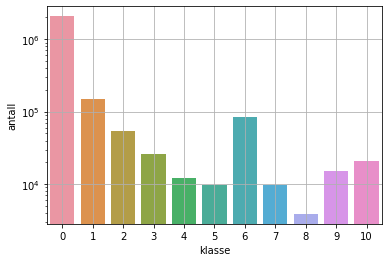

In [126]:
a = pd.DataFrame(np.sum(dist, axis=0).T, columns = ["klasse", "antall"])
a["label"] = ["None", "unknown", "black concrete", "metal roofing", "black ceramic", "brown concrete", 
           "red concrete", "gravel", "green ceramic", "pcv", "tar roofing paper"]
a.klasse = (a.klasse / 150).astype(int)
sns.reset_orig()
g= sns.barplot(data=a, x="klasse", y="antall")
g.set_yscale("log")
plt.grid()

In [10]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [11]:
y_test = y_test.reshape((y_test.shape[0],y_test.shape[1], y_test.shape[2], 1))

In [12]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(120, 128, 128, 11)
(30, 128, 128, 11)
(24, 128, 128, 11)


# Dimension reduction - PCA

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components=10)
X_train[:,:,:,:-1].reshape(X_train.shape[0]*X_train.shape[1]*X_train.shape[2],
                                   X_train.shape[3]-1).shape

pca.fit(X_train[:,:,:,:-1].reshape(X_train.shape[0]*
                                   X_train.shape[1]*X_train.shape[2],
                                   X_train.shape[3]-1))



PCA(n_components=10)

In [15]:
def mypca(X,y):
  ndsm = X[:,:,:,-1]
  hs = X[:,:,:,:-1]

  hs_pca = pca.transform(hs.reshape(hs.shape[0]*hs.shape[1]*hs.shape[2], 
                                    hs.shape[3])).reshape(hs.shape[0], hs.shape[1], hs.shape[2], 10)
  ndsm = ndsm.reshape(ndsm.shape[0], ndsm.shape[1], ndsm.shape[2], 1)
  hs_pca = np.append(hs_pca, ndsm, axis=3)
  return hs_pca

In [16]:
X_train = mypca(X_train, None)
X_val = mypca(X_val, None)
X_test = mypca(X_test, None)

In [45]:
X_test.shape

(24, 128, 128, 11)

# Pick out some wavelenghts

In [55]:
idx = np.append(np.arange(0,399,step=3), 398)

X_train = X_train[:,:,:,idx]
X_val = X_val[:,:,:,idx]
X_test = X_test[:,:,:,idx]

In [56]:
X_train.shape

(150, 128, 128, 134)

# Bring togheter wavelenghts

In [70]:
idx = np.arange(0,398,step=10)

def mean_waves(X_data):
  ndsm = X_data[:,:,:,-1]
  hs = X_data[:,:,:,:-1]

  X = None
  for i in idx:
    if i+10 > 398:
      i = 398 - 10
    if X is not None:
      temp = np.mean(hs[:,:,:,i:i+10], axis=3)
      temp = temp.reshape(temp.shape[0], temp.shape[1], temp.shape[2], 1)
      X = np.append(X, temp, axis=3)
      pass
    else:
      X = np.mean(hs[:,:,:,i:i+10], axis=3)
      X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

  ndsm = ndsm.reshape(ndsm.shape[0], ndsm.shape[1], ndsm.shape[2], 1)
  X = np.append(X, ndsm, axis=3)

  return X

In [71]:
X_train = mean_waves(X_train)
X_val = mean_waves(X_val)
X_test = mean_waves(X_test)

In [72]:
X_train.shape

(150, 128, 128, 41)

# Set up metrics/loss

In [13]:
def multi_mcc_loss(y_true, y_pred, false_pos_penal=1.0):
    # Reshape image to flatten form
    y_true = K.reshape(y_true, [-1, y_true.shape[-1]])
    y_pred = K.reshape(y_pred, [-1, y_pred.shape[-1]])

    confusion_m = tf.matmul(K.transpose(y_true), y_pred)
    if false_pos_penal != 1.0:
      """
      This part is done for penalization of FalsePos symmetrically with FalseNeg,
      i.e. FalseNeg is favorized for the same factor. In such way MCC values are comparable.
      If you want to penalize FalseNeg, than just set false_pos_penal < 1.0 ;)
      """
      confusion_m = tf.linalg.band_part(confusion_m, 0, 0) + tf.linalg.band_part(confusion_m, 0, -1)*false_pos_penal + tf.linalg.band_part(confusion_m, -1, 0)/false_pos_penal
    
    N = K.sum(confusion_m)
    
    up = N*tf.linalg.trace(confusion_m) - K.sum(tf.matmul(confusion_m, confusion_m))
    down_left = K.sqrt(N**2 - K.sum(tf.matmul(confusion_m, K.transpose(confusion_m))))
    down_right = K.sqrt(N**2 - K.sum(tf.matmul(K.transpose(confusion_m), confusion_m)))
    
    mcc = up / (down_left * down_right + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    
    return 1 - K.mean(mcc)

def multi_mcc(y_true, y_pred, false_pos_penal=1.0):
    # Reshape image to flatten form
    #y_true = tf.convert_to_tensor(y_true)
    #y_pred = tf.convert_to_tensor(y_pred)
    y_true = K.reshape(y_true, [-1, y_true.shape[-1]])
    y_pred = K.reshape(y_pred, [-1, y_pred.shape[-1]])

    confusion_m = tf.matmul(K.transpose(y_true), y_pred)
    if false_pos_penal != 1.0:
      """
      This part is done for penalization of FalsePos symmetrically with FalseNeg,
      i.e. FalseNeg is favorized for the same factor. In such way MCC values are comparable.
      If you want to penalize FalseNeg, than just set false_pos_penal < 1.0 ;)
      """
      confusion_m = tf.linalg.band_part(confusion_m, 0, 0) + tf.linalg.band_part(confusion_m, 0, -1)*false_pos_penal + tf.linalg.band_part(confusion_m, -1, 0)/false_pos_penal
    
    N = K.sum(confusion_m)
    up = N*tf.linalg.trace(confusion_m) - K.sum(tf.matmul(confusion_m, confusion_m))
    down_left = K.sqrt(N**2 - K.sum(tf.matmul(confusion_m, K.transpose(confusion_m))))
    down_right = K.sqrt(N**2 - K.sum(tf.matmul(K.transpose(confusion_m), confusion_m))) 
    
    mcc = up / (down_left * down_right + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    return K.mean(mcc)


# Set up model

In [26]:
#base_model = sm.Unet(backbone_name='resnet34', encoder_weights='imagenet',
#                     classes=11, activation='softmax', encoder_freeze=True)

#inp = Input(shape=(128, 128, 399))
#l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
#out = base_model(l1)

#model = Model(inp, out, name=base_model.name)

model = sm.Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(128, 128, X_train.shape[-1]),
                classes=11, activation='softmax')

In [27]:
#u = vanilla_unet()
#inp = Input(shape=(128, 128, 399))
#model = u.get_unet(inp, None, n_classes=11, last_activation="softmax")

In [28]:
from segmentation_models.losses import CategoricalFocalLoss
from sklearn.metrics import matthews_corrcoef
from segmentation_models.losses import JaccardLoss
from segmentation_models.losses import DiceLoss
from segmentation_models.losses import CategoricalCELoss

loss = CategoricalFocalLoss()
j_loss = JaccardLoss()
d_loss = DiceLoss()
loss = loss + j_loss
#loss = CategoricalCELoss()

f1 = tfa.metrics.F1Score(num_classes=11, average='micro')
model.compile(optimizer='adam',
                loss=loss,
                metrics=[f1, multi_mcc])

In [17]:
#K.clear_session()

In [29]:
def train(epochs):
  h = model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs, verbose=2)
  return h

h = train(200)
#train(50)
#model.save("model50.h5")
#train(50)
#model.save("model100.h5")
#train(100)
#model.save("model200.h5")
#train(100)
#model.save("model300.h5")

Epoch 1/200
4/4 - 9s - loss: 1.0148 - f1_score: 0.2155 - multi_mcc: 0.0082 - val_loss: 1.3474 - val_f1_score: 0.0334 - val_multi_mcc: 0.0075 - 9s/epoch - 2s/step
Epoch 2/200
4/4 - 2s - loss: 0.9924 - f1_score: 0.5416 - multi_mcc: 0.0358 - val_loss: 1.3442 - val_f1_score: 0.0388 - val_multi_mcc: 0.0036 - 2s/epoch - 511ms/step
Epoch 3/200
4/4 - 2s - loss: 0.9719 - f1_score: 0.7121 - multi_mcc: 0.0709 - val_loss: 1.0178 - val_f1_score: 0.7533 - val_multi_mcc: 0.0017 - 2s/epoch - 501ms/step
Epoch 4/200
4/4 - 2s - loss: 0.9497 - f1_score: 0.8005 - multi_mcc: 0.1095 - val_loss: 1.3093 - val_f1_score: 0.1203 - val_multi_mcc: 0.0039 - 2s/epoch - 499ms/step
Epoch 5/200
4/4 - 2s - loss: 0.9274 - f1_score: 0.8380 - multi_mcc: 0.1529 - val_loss: 1.3224 - val_f1_score: 0.0934 - val_multi_mcc: 0.0042 - 2s/epoch - 500ms/step
Epoch 6/200
4/4 - 2s - loss: 0.9043 - f1_score: 0.8549 - multi_mcc: 0.1996 - val_loss: 0.9835 - val_f1_score: 0.8362 - val_multi_mcc: -8.0351e-03 - 2s/epoch - 500ms/step
Epoch 7/

In [14]:
#model50 = model
#model50 = model.copy()
#modell100 - modell200 - model300
model.save("model50.h5")

In [31]:
#all_his = {}
all_his["vanilla_unet"] = h

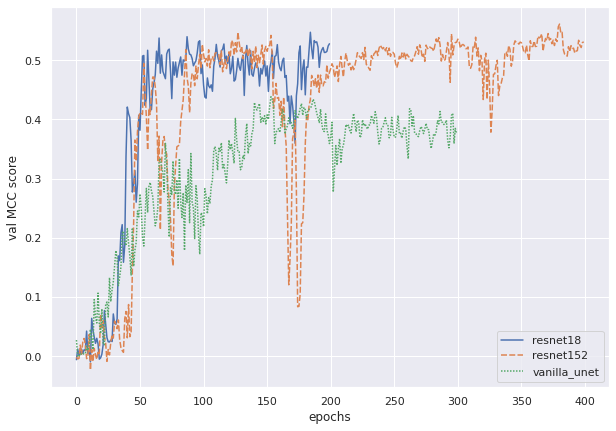

In [32]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10,7))
data = sns.lineplot(data={i:all_his[i].history["val_multi_mcc"][:] for i in ["resnet18", "resnet152", "vanilla_unet"]}, ax=ax)
ax.set_xlabel("epochs"); ax.set_ylabel("val MCC score")

labels = np.array([int(item) for item in ax.get_xticks()])
ax.set_xticklabels(labels)
plt.show()

Text(0.5, 1.0, 'scorings')

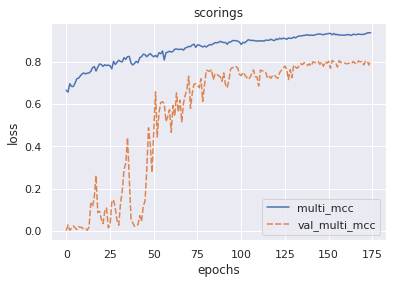

In [30]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][25:]) for key in ['multi_mcc','val_multi_mcc']})
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("scorings")

# Show pred data

In [19]:
rød = X_test[:,:,:,81]; grønn = X_test[:,:,:,46]; blå = X_test[:,:,:,21];
rgb = [np.dstack((r,g,b)) for r,g,b in zip(rød,grønn,blå)]
rgb = np.array(rgb)

nx = 6
ny = 2

def arange_image(img, o=0):
  u = []
  o = o
  for i in range(int(nx)):
    b = np.array(img[o])
    o += 1
    for j in range(1,int(ny)):
      b = np.append(b, img[o], axis=1)
      o += 1
                  
    if len(u) == 0:
      u = b
    else:
      u = np.append(u, b, axis=0)
  return u


In [12]:
#import keras

In [23]:
#model.load_weights("model50.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


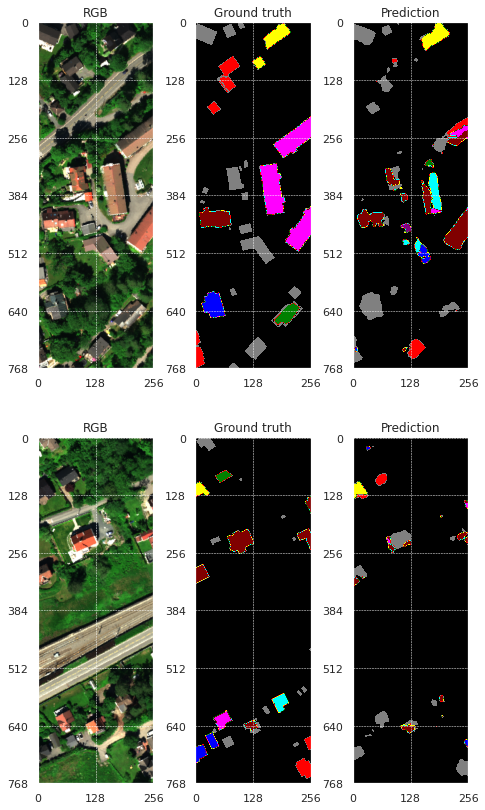

In [38]:
classes = ["None", "unknown", "black concrete", "metal roofing", "black ceramic", "brown concrete", 
           "red concrete", "gravel", "green ceramic", "pcv", "tar roofing paper"]

colormap = ListedColormap(["black", "gray", "red", "green", "yellow", "cyan", "maroon",
                           "magenta", "seagreen", "purple", "blue"])

y = y_test.argmax(axis=3)

def set_grid(ax):
  ax.set_yticks([j*128 for j in range(0,nx+1)])
  ax.set_xticks([j*128 for j in range(0,ny+1)])
  ax.grid(color='w', linestyle='--', linewidth=0.5)

#sns.set_context(rc={"lines.linewidth": 128})
for name in ["hi"]:
  #model.load_weights(name)
  pred = model.predict(X_test)
  p = np.argmax(pred,axis=3)

  u1,u2 = arange_image(rgb, o=0), arange_image(rgb, o=12)
  v1,v2 = arange_image(y, o=0), arange_image(y, o=12)
  w1,w2 = arange_image(p, o=0), arange_image(p, o=12)

  w1[0:11, 0] = [0,1,2,3,4,5,6,7,8,9,10]
  w2[0:11, 0] = [0,1,2,3,4,5,6,7,8,9,10]

  #sns.reset_orig()
  fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,14))

  for ax,bilde in [(axs[0,0],u1),(axs[1,0],u2)]:
    ax.imshow(bilde/2500); ax.set_title("RGB")
    set_grid(ax)

  for ax,bilde in [(axs[0,1],v1),(axs[1,1],v2)]:
    ax.imshow(bilde, cmap=colormap); ax.set_title("Ground truth")
    set_grid(ax)

  for ax,bilde in [(axs[0,2],w1),(axs[1,2],w2)]:
    im = ax.imshow(bilde, cmap=colormap); ax.set_title("Prediction")
    set_grid(ax)


  #cbar = plt.colorbar(im, cmap=colormap)
  #n_clusters = 11
  #tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
  #cbar.set_ticks(tick_locs)
  # set tick labels (as before)
  #cbar.set_ticklabels(classes)

  plt.show()
